# Exploration
In this document we work using a new method, based on tree. In the previous exploration we mentioned that the classification using logistic regression is associated with linearity speration and there is no regularisation in the nevironment, it possible to implement it but we did not take this option yet (perhaps later).
Tree oriented is a solution to avoid the instabilty associated with linearity separation, in this document we explore the mixed effect based on the customers (Hot, Warm), this couls allow us to build one model instead of two. 

In [72]:
import gpboost as gpb
import pandas  as pd
import numpy   as np
import vtreat
# For some display
import matplotlib.pyplot as plt

# The data set
We import the same data set as in the model notebook after pre process of the varaibles project_status and type. In the model document we use the conditional probability of the the effect after the transformation of type, as we rae with tree we shall do the following:

1. Test the mixed effect boostiong without conditional probability
2. Test with with conditional probability

In [10]:
# We read our data they have been prepared
all_data = pd.read_csv("../data/dulux_preprocess.csv")

For information, we have the following variables in this data set, as mentioned we use a sub-set. As note we can admire the precision of Python!!!

In [11]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5342 entries, 0 to 5341
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Unnamed: 0                           5342 non-null   int64  
 1   Unnamed: 0.1                         5342 non-null   int64  
 2   projectid                            5342 non-null   int64  
 3   name                                 5342 non-null   object 
 4   company                              5342 non-null   object 
 5   qualification_level_code_text        5342 non-null   object 
 6   user_status_code_text                5342 non-null   object 
 7   account_life_cycle_status_code_text  5342 non-null   object 
 8   priority_code_text                   5342 non-null   object 
 9   group_code_text                      5342 non-null   object 
 10  account_state                        5307 non-null   object 
 11  consistency_status_code_text  

## Tranaformation for mixed effect
As we work with mixed model we have other transformations, 

As in the model, we build Hot and Warm, we shall work on Hot only in this document as we do an exploration. 

In [14]:
# We do a log transformed and then split in warm and hot 
# The varaiables used have been selected based on the analysis of the effect
all_data['log_value']  = np.log(all_data['value'])
variable_name =[ 'company', 'opportunity','type','log_value', 'account_state', 'project_status', 'projectstage', 'consistency_status_code_text', 'life_cycle_status_code_text']
# Split 
warm_data  = all_data[ all_data['qualification_level_code_text'] =='Warm']
hot_data   = all_data[ all_data['qualification_level_code_text'] =='Hot' ]
#  Reduce 
col_pos =[]
for ref in variable_name:
        col_pos.append(all_data.columns.get_loc(ref))
        
warm_data  = warm_data.iloc[:,col_pos]    
hot_data   = hot_data.iloc[:,col_pos]       

# Mixed model & Boosting

In [66]:
import sklearn.datasets as datasets
m       = 500  # number of categories / levels for grouping variable
n       = 10000
ntrain  = 5000
np.random.seed(35)
rd_x, rd_f = datasets.make_friedman3( n_samples=ntrain)  # Non linear generation
#  Build the  variates
pd_x = pd.DataFrame(rd_x,columns=['variable_1','variable_2','variable_3','variable_4'])
# The fixed effect 
rd_f = rd_f * 10**0.5

Show the fixed effect distribution 

(0.0, 800.0)

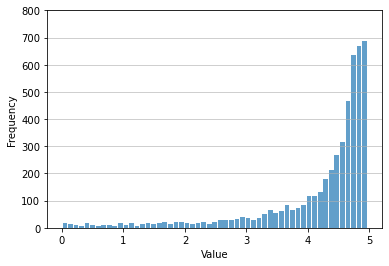

In [68]:
n, bins, patches = plt.hist(x=rd_f, bins='auto', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.ylim(ymax=800)


In [69]:
# Simulate random effects we build the groups index 
group_train = np.arange(ntrain)  # grouping variable
for i in range(m):
    group_train[int(i * ntrain / m):int((i + 1) * ntrain / m)] = i

We build the train data set with response and random effect 

In [70]:
#  Build the random effect 
sigma2_1 = 1  # random effect variance
sigma2 = 1 ** 2  # error variance
b = np.sqrt(sigma2_1) * np.random.normal(size=ntrain)  # simulate random effects

Zb = b[group_train]
# Put everything together for the response
xi = np.sqrt(sigma2) * np.random.normal(size=ntrain)  # simulate error term
y = rd_f + Zb + xi  # observed data

In [ ]:
Build the model using the GP boost

In [73]:
# Define and train GPModel
gp_model = gpb.GPModel(group_data=group_train)
# create dataset for gpb.train function
data_train = gpb.Dataset(pd_x, y)
# specify tree-boosting parameters as a dict
params = { 'objective': 'regression_l2', 'learning_rate': 0.1, 'max_depth': 6, 'min_data_in_leaf': 5, 'verbose': 0 }
# train model
bst = gpb.train(params=params, train_set=data_train, gp_model=gp_model, num_boost_round=32)
gp_model.summary() # estimated covariance parameters

Covariance parameters 
['Error_term', 'Group_1']
[0.89285775 1.00095865]


In [ ]:
We predict on the train set here, we did no build a test set as we explore. The result is not really great. 

In [74]:
# Make predictions
pred = bst.predict(data=pd_x, group_data_pred=group_train)
y_pred = pred['fixed_effect'] + pred['random_effect_mean'] # sum predictions of fixed effect and random effect
np.sqrt(np.mean((y - y_pred) ** 2)) # root mean square error (RMSE) on test data. Approx. = 1.25

0.9003394820504346

In [78]:
y.max()

10.612918971944973

In [79]:
y.min()

-2.9105534010215193

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

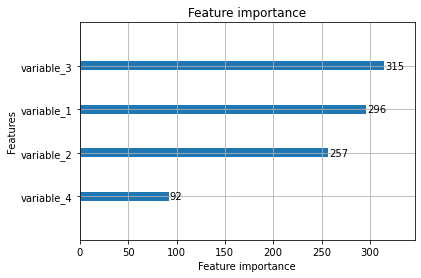

In [80]:
# Plotting feature importances
gpb.plot_importance(bst)